In [1]:
%load_ext autoreload
%autoreload 2

from imports import *
from dynamics import *
from model import *

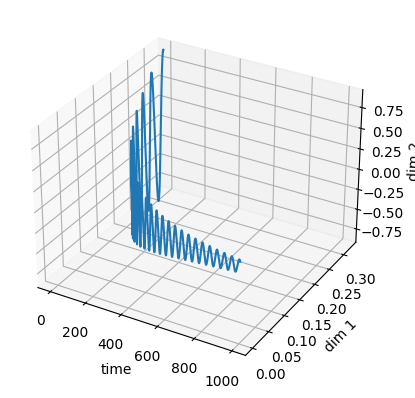

In [2]:
data = dampened_oscillator(m=1.0, c=np.array([100.0, 0.1]), k=np.array([10.0, 10.0]))

plot_3d(data.cpu().numpy())

In [3]:
def loss_fn(model, batch, num_negative_samples):
    margin = 2
    beta = 1

    '''
    positive term loss
    '''
    # E_x_tp1_positive - E_x_t
    min_difference = model(batch[1:, :]) - model(batch[:-1, :])

    positive_loss = torch.mean(torch.maximum(torch.zeros_like(min_difference).cuda(), margin + min_difference)**2)

    '''
    negative samples: previous `num_negative_samples` in the trajectory given current x_t (i.e. x_{t - num_negative_samples} ... x_{t-1})
    '''
    negative_loss = []

    for i in range(batch.shape[0]-1):
        num_samples = min(i, num_negative_samples)

        if num_samples:
            # E_x_tp1_negative - E_x_t
            max_difference = model(batch[np.random.choice(i, size=(num_samples,), replace=False), :]) - model(batch[i, :].unsqueeze(0)).repeat(num_samples)
            
            '''
            hinge loss with margin
            '''
            loss = torch.sum(
                torch.maximum(torch.zeros_like(max_difference).cuda(), margin - max_difference)**2
            )

            '''
            Gibbs partition function based loss
            '''
            # loss = 1/beta * torch.log(torch.sum(torch.exp(-beta * max_difference)))

            '''
            negative exponential loss
            '''
            # loss = torch.sum(torch.exp(-max_difference))

            negative_loss.append(loss)

    return positive_loss + sum(negative_loss)/len(negative_loss)


def plot_energy_along_trajectory(model, trajectory):
    with torch.no_grad():
        E_x_t = []

        for x_t in trajectory:
            E_x_t.append(model(x_t.unsqueeze(0)).squeeze().detach().cpu().item())

    plt.plot(E_x_t)
    plt.title("energy along trajectory")

    plt.show()


def plot_energy_landscape(model):
    X = torch.linspace(-10, 10, steps=500)
    Y = torch.linspace(-10, 10, steps=500)

    energy_manifold = model(torch.cartesian_prod(X, Y).cuda()).reshape(X.shape[0], Y.shape[0]).detach().cpu().numpy()

    X, Y = np.meshgrid(X.numpy(), Y.numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(X, Y, energy_manifold, cmap='viridis', edgecolor='k', linewidth=0.5, facecolor=(1,1,1,0.2))

    fig.colorbar(surface, pad=0.1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$energy$')
    ax.set_title('energy landscape')
    
    plt.show()


def epoch(iterations, model, optimizer, data, bs, num_negative_samples):
    losses = []

    for i in range(iterations):
        batch = generate_batch(data, bs=bs)

        optimizer.zero_grad()

        loss = loss_fn(model, batch, num_negative_samples=num_negative_samples)

        loss.backward()

        optimizer.step()

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

  2%|▏         | 1/50 [00:03<03:03,  3.75s/it]

147.8249954223633


  4%|▍         | 2/50 [00:07<02:51,  3.57s/it]

147.17557678222656


  6%|▌         | 3/50 [00:10<02:45,  3.52s/it]

146.40624237060547


  8%|▊         | 4/50 [00:14<02:41,  3.50s/it]

144.44021453857422


 10%|█         | 5/50 [00:17<02:37,  3.50s/it]

147.3445083618164


 12%|█▏        | 6/50 [00:21<02:33,  3.48s/it]

115.72842025756836


 14%|█▍        | 7/50 [00:24<02:28,  3.46s/it]

143.15803985595704


 16%|█▌        | 8/50 [00:27<02:25,  3.46s/it]

194.05555877685546


 18%|█▊        | 9/50 [00:31<02:21,  3.45s/it]

143.78868103027344


 20%|██        | 10/50 [00:34<02:17,  3.45s/it]

142.5510482788086


 22%|██▏       | 11/50 [00:38<02:14,  3.44s/it]

146.98843841552736


 24%|██▍       | 12/50 [00:41<02:11,  3.45s/it]

143.7769287109375


 26%|██▌       | 13/50 [00:45<02:07,  3.45s/it]

138.35625762939452


 28%|██▊       | 14/50 [00:48<02:04,  3.46s/it]

137.97472076416017


 30%|███       | 15/50 [00:52<02:00,  3.46s/it]

144.79477233886718


 32%|███▏      | 16/50 [00:55<01:57,  3.45s/it]

138.82145080566406


 34%|███▍      | 17/50 [00:58<01:53,  3.45s/it]

147.98514251708986


 36%|███▌      | 18/50 [01:02<01:50,  3.45s/it]

131.72235870361328


 38%|███▊      | 19/50 [01:05<01:46,  3.45s/it]

117.09197387695312


 40%|████      | 20/50 [01:09<01:43,  3.44s/it]

123.00371704101562


 42%|████▏     | 21/50 [01:12<01:39,  3.44s/it]

132.36129989624024


 44%|████▍     | 22/50 [01:16<01:36,  3.44s/it]

112.3588363647461


 46%|████▌     | 23/50 [01:19<01:32,  3.43s/it]

127.94404830932618


 48%|████▊     | 24/50 [01:23<01:29,  3.43s/it]

107.8144432067871


 50%|█████     | 25/50 [01:26<01:25,  3.43s/it]

84.78634147644043


 52%|█████▏    | 26/50 [01:29<01:22,  3.42s/it]

95.91741218566895


 54%|█████▍    | 27/50 [01:33<01:18,  3.43s/it]

36.94453430175781


 56%|█████▌    | 28/50 [01:36<01:15,  3.42s/it]

152.5563694000244


 58%|█████▊    | 29/50 [01:40<01:11,  3.43s/it]

63.71413402557373


 60%|██████    | 30/50 [01:43<01:08,  3.43s/it]

124.38325424194336


 62%|██████▏   | 31/50 [01:47<01:05,  3.44s/it]

167.33404083251952


 64%|██████▍   | 32/50 [01:50<01:01,  3.39s/it]

72.47060337066651


 66%|██████▌   | 33/50 [01:53<00:56,  3.31s/it]

55.986548614501956


 68%|██████▊   | 34/50 [01:56<00:52,  3.26s/it]

106.95722198486328


 70%|███████   | 35/50 [01:59<00:48,  3.23s/it]

133.64369506835936


 72%|███████▏  | 36/50 [02:02<00:44,  3.20s/it]

115.11233062744141


 74%|███████▍  | 37/50 [02:06<00:41,  3.18s/it]

41.97559661865235


 76%|███████▌  | 38/50 [02:09<00:38,  3.17s/it]

51.23700847625732


 78%|███████▊  | 39/50 [02:12<00:34,  3.16s/it]

81.653071975708


 80%|████████  | 40/50 [02:15<00:31,  3.16s/it]

61.49979457855225


 82%|████████▏ | 41/50 [02:18<00:28,  3.16s/it]

66.86076374053955


 84%|████████▍ | 42/50 [02:21<00:25,  3.15s/it]

37.57650890350342


 86%|████████▌ | 43/50 [02:24<00:22,  3.15s/it]

135.3604393005371


 88%|████████▊ | 44/50 [02:28<00:18,  3.16s/it]

253.76210021972656


 90%|█████████ | 45/50 [02:31<00:15,  3.15s/it]

47.24159336090088


 92%|█████████▏| 46/50 [02:34<00:12,  3.15s/it]

57.7064603805542


 94%|█████████▍| 47/50 [02:37<00:09,  3.14s/it]

56.368626022338866


 96%|█████████▌| 48/50 [02:40<00:06,  3.14s/it]

30.078555583953857


 98%|█████████▊| 49/50 [02:43<00:03,  3.14s/it]

113.17673568725586


100%|██████████| 50/50 [02:46<00:00,  3.34s/it]

33.31565227508545


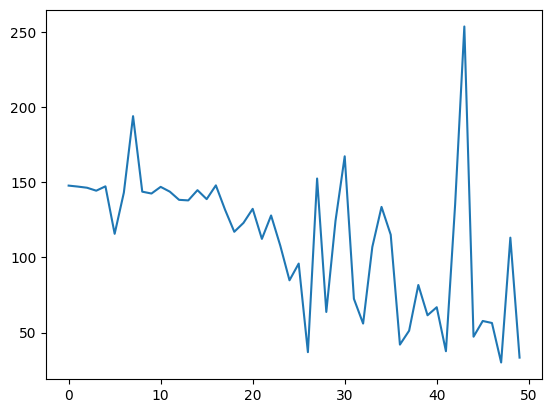

In [4]:
model = EBM(2).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

losses = []

for e in tqdm(range(50)):
    data = dampened_oscillator(m=1.0, c=np.array([100.0, 0.1]), k=np.array([10.0, 10.0]))
    
    loss = epoch(iterations=10, model=model, optimizer=optimizer, data=data, bs=200, num_negative_samples=40)
    losses.append(loss)
    print(loss)

plt.plot(losses)

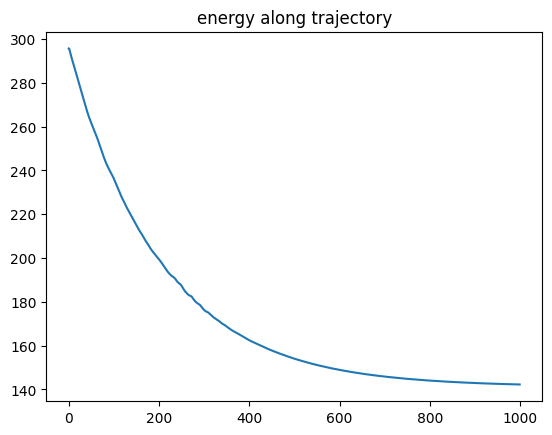

In [8]:

plot_energy_along_trajectory(model, dampened_oscillator(m=1.0, c=np.array([100.0, 0.1]), k=np.array([10.0, 10.0])))

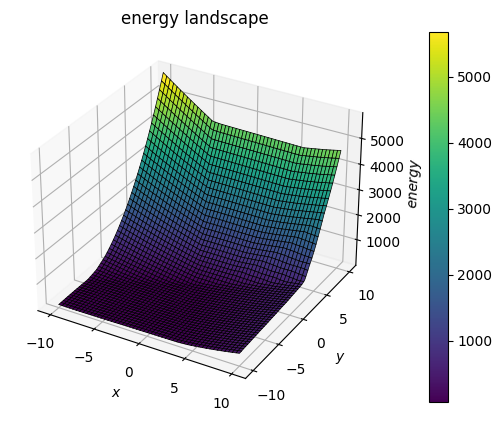

In [9]:
plot_energy_landscape(model)

In [ ]:
def evaluate(model, x_ts,reseed=1):
    """Evaluates the model on given dataset.
    Args:
        model (nn.Module): The neural network model.
        x_ts (torch.Tensor): The current state tensor.
        
    Returns:
        np.ndarray: Array of prediction errors.
        np.ndarray 
    """

    errors = []
    preds, actuals = [],[]
    grads = []
    x_t_inferred = x_t = x_ts[0]
    step_counter = 0

    for _ in range(1,len(x_ts)):
        x_t.requires_grad_(True)  # Ensure that x_t has requires_grad=True
        
        E_xt = model(x_t.reshape(1,-1))
        E_xt.backward(torch.ones_like(E_xt))
        grad_E_xt = x_t.grad

        grads.append(grad_E_xt.detach().numpy())
        
        if step_counter < reseed - 1: #reseed = 1 means we substitute every step, so - 1
            prev = x_t_inferred
        else:
            prev = x_t
            step_counter = 0
            
        x_t_inferred = prev - 0.05 * grad_E_xt
        step_counter += 1
        x_t_actual = x_ts[_]
        error = torch.norm(x_t_inferred.detach() - x_t_actual, dim=-1).numpy()
        errors.append(error)
        x_t = x_t_actual
        preds.append(x_t_inferred.detach().numpy())
        actuals.append(x_t_actual.detach().numpy())

    return np.stack(errors),np.array(preds).squeeze(),np.array(actuals).squeeze(),np.array(grads).squeeze()